# Práctica 1 - Ejercicio 1

Asignatura: Programación para la Inteligencia Artificial

Alumno: Jesús García Gaitán

En esta práctica se tienen que realizar dos ejercicios en dos cuadernos de Jupyter separados. Este es el primer ejercicio y el segundo se proporcionará durante la siguiente sesión de prácticas.

El primer ejercicio tiene como objetivo entrenar un modelo neuronal de capas lineales con PyTorch que ajuste simultáneamente las funciones siguientes:

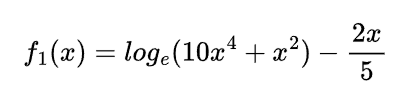

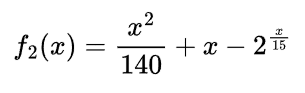

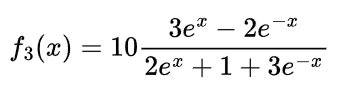

El modelo debe tener una entrada (x), tres salidas (f<sub>1</sub>(x), f<sub>2</sub>(x) y f<sub>3</sub>(x)) y debe ser capaz de generalizar en el rango x∈[-120,120]. Los datos para el entrenamiento se deben generar usando PyTorch con un error de media 0 y desviación típica 5 siguiendo una estrategia similar a la vista en clase. Para gestion de los datos durante el entrenamiento es requisito obligatorio usar *DataLoaders*.

Como resultado se espera este mismo cuaderno editado que incluya el código y los experimentos más relevantes realizados para alcanzar la mejor solución encontrada. Como resultado de esos experimentos, siguiendo lo visto en clase, se espera la visualización de las funciones aprendidas por el modelo y un breve análisis.

En los experimentos es obligatorio usar, además del subconjunto de entrenamiento, un subconjunto de validación durante el entrenamiento y un subconjunto de test que se usará solo después del entrenamiento para obtener una medida de error final. Esa medida del error final se debe realizar usando la media del error absoluto. Tanto el subconjunto de validación como el subconjunto de test deben contar con 500 ejemplos. El tamaño del conjunto de entrenamiento queda a criterio del estudiante.

El cuaderno entregado debe llamarse ApellidosNombrePractica1Ejercicio1.ipynb


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

### Funciones y definición de métodos

In [2]:
# Funciones

def f1(x):
    # f(x) = log_e(10x^4 + x^2) - 2x/5
    return torch.log(10 * x**4 + x**2) - 2 * x / 5

def f2(x):
    # f2(x) = x^2/140 + x - 2^(x/15)
    # Limitamos el exponente para evitar overflow
    exp_term = torch.clamp(x/15, -10, 10)
    return (x**2)/140 + x - torch.pow(2, exp_term)

def f3(x):
    # f(x) = 10*(3e^x - 2e^-x) / (2e^x + 1 + 3e^-x)
    # Limitamos el exponente para evitar overflow
    exp_pos = torch.exp(torch.clamp(x, -20, 20))
    exp_neg = torch.exp(torch.clamp(-x, -20, 20))
    return 10*((3*exp_pos - 2*exp_neg)/(2*exp_pos + 1 + 3*exp_neg))

def get_data_from_a_polynomial(poly_list, n, sigma=5, data_range=120):
    x = 2*data_range*torch.rand(n)-data_range
    noise_x = torch.normal(torch.zeros_like(x), sigma*torch.ones_like(x))
    x_with_noise = x + noise_x

    y_list = []
    for poly in poly_list:
      y = poly(x_with_noise)
      noise_y = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y))
      y_with_noise = y + noise_y
      y_list.append(y_with_noise)

    y_stacked = torch.stack(y_list, dim=1)
    return x_with_noise, y_stacked, y_list

class XYDataset(Dataset):
    def __init__(self, x, y):
        self.x_original = x
        self.x_normalized = x / 120
        self.y = y

    def __len__(self):
        return self.x_original.numel()

    def __getitem__(self, idx):
        x = torch.tensor([self.x_normalized[idx]], dtype=torch.float32)
        y = self.y[idx].float()
        return x, y


# Loop de entrenamiento con validación

def learning_loop_with_val(train_loader, val_loader, model, epochs, loss_fn, lr, optimizer_cls):
    train_losses = []
    val_losses = []
    optimizer = optimizer_cls(model.parameters(), lr=lr)

    for epoch in tqdm(range(epochs)):
        model.train()
        batch_losses = []
        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_losses.append(sum(batch_losses)/len(batch_losses))

        if epoch % 10 == 0:
            model.eval()
            val_batch_losses = []
            with torch.no_grad():
                for x, y in val_loader:
                    y_pred = model(x)
                    loss = loss_fn(y_pred, y)
                    val_batch_losses.append(loss.item())
            val_losses.append(sum(val_batch_losses)/len(val_batch_losses))
    return model, train_losses, val_losses



### Generación de datasets y dataloaders de entrenamiento, validación y test

In [3]:
# Generación de datos

n_train = 2000
n_val_test = 500
data_range = 120
sigma = 5

# Entrenamiento
x_train, y_train_stacked, y_train_list= get_data_from_a_polynomial([f1,f2,f3], n_train, sigma=sigma, data_range=data_range)
train_dataset = XYDataset(x_train, y_train_stacked)

# Validación
x_val, y_val_stacked, y_val_list = get_data_from_a_polynomial([f1,f2,f3], n_val_test, sigma=sigma, data_range=data_range)
val_dataset = XYDataset(x_val, y_val_stacked)

# Test
x_test, y_test_stacked, y_test_list = get_data_from_a_polynomial([f1,f2,f3], n_val_test, sigma=sigma, data_range=data_range)
test_dataset = XYDataset(x_test, y_test_stacked)


# DataLoaders

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### EXPERIMENTO 1

Modelo de 3 capas (12, 12, 16) con 2000 épocas, tasa de aprendizaje 1e-3.

Todos los experimentos los realizaremos con L1Loss y con el optimizador SGD (descenso de gradiente estocástico).

100%|██████████| 2000/2000 [05:22<00:00,  6.20it/s]


Error absoluto medio en validación: 6.6373


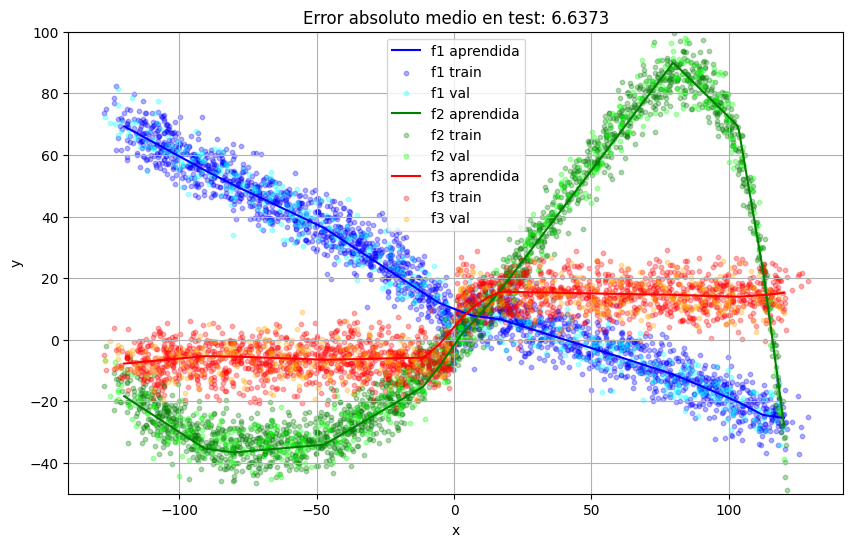

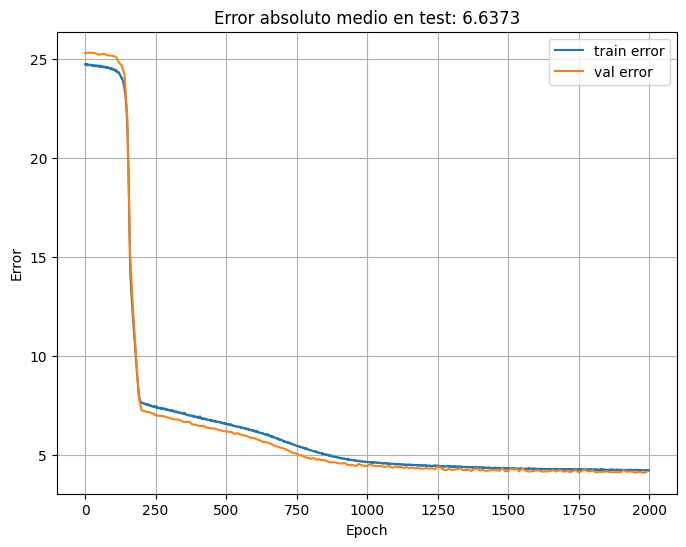

In [9]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 12),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(12, 12),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(12, 16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16, 3),  # 3 salidas
)


# Hiperparámetros
epochs = 2000
learning_rate = 1e-3
loss_fn = torch.nn.L1Loss()
optimizer_cls = torch.optim.SGD

model, train_losses, val_losses = learning_loop_with_val(train_loader, val_loader, model, epochs, loss_fn, learning_rate, optimizer_cls)


# Calculamos el error medio de todas las épocas de validación
mean_val_error = sum(val_losses) / len(val_losses)
print(f"Error absoluto medio en validación: {mean_val_error:.4f}")


# PLOTS
# ----------------------------
# Convertimos dataset a tensores para plotear
x_full_range = torch.linspace(-120,120,500)[:,None]
x_plot_normalized = x_full_range / 120
y_plot = model(x_plot_normalized).detach()

plt.figure(figsize=(10,6))
plt.title(f"Error absoluto medio en test: {mean_val_error:.4f}")
plt.plot(x_full_range, y_plot[:,0], c='b', label='f1 aprendida')
plt.scatter(x_train, y_train_list[0], c='b', s=10, alpha=0.3, label='f1 train')
plt.scatter(x_val, y_val_list[0], c='cyan', s=10, alpha=0.3, label='f1 val')
plt.plot(x_full_range, y_plot[:,1], c='g', label='f2 aprendida')
plt.scatter(x_train, y_train_list[1], c='g', s=10, alpha=0.3, label='f2 train')
plt.scatter(x_val, y_val_list[1], c='lime', s=10, alpha=0.3, label='f2 val')
plt.plot(x_full_range, y_plot[:,2], c='r', label='f3 aprendida')
plt.scatter(x_train, y_train_list[2], c='r', s=10, alpha=0.3, label='f3 train')
plt.scatter(x_val, y_val_list[2], c='orange', s=10, alpha=0.3, label='f3 val')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-50, 100)
plt.show()


# Ploteamos la gráfica del error
plt.figure(figsize=(8,6))
plt.title(f"Error absoluto medio en test: {mean_val_error:.4f}")
plt.plot(train_losses, label="train error")
plt.plot(range(0, epochs, 10), val_losses, label="val error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()


En este primer intento, el modelo de red neuronal es bastante sencillo y no se entrenó mucho tiempo. Como se puede ver en la primera gráfica, aprende a seguir la forma de las funciones f1 (azul) y f3 (roja) más o menos bien, pero le cuesta más trabajo entender la función f2 (verde), sobre todo en las curvas de x -100/-50 y 50/100, que se quedan muy planas y con el giro muy esquinado. La gráfica de error muestra que, aunque el error de validación baja, se sigue manteniendo un poco alto, lo que nos dice que al modelo le falta "potencia" o más tiempo de entrenamiento para poder aprenderse bien las funciones.



### EXPERIMENTO 2

Modelo de 4 capas (64, 64, 32, 16) con 2000 épocas y tasa de aprendizaje 1e-3

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [05:47<00:00,  5.75it/s]


Error absoluto medio en validación: 5.7418


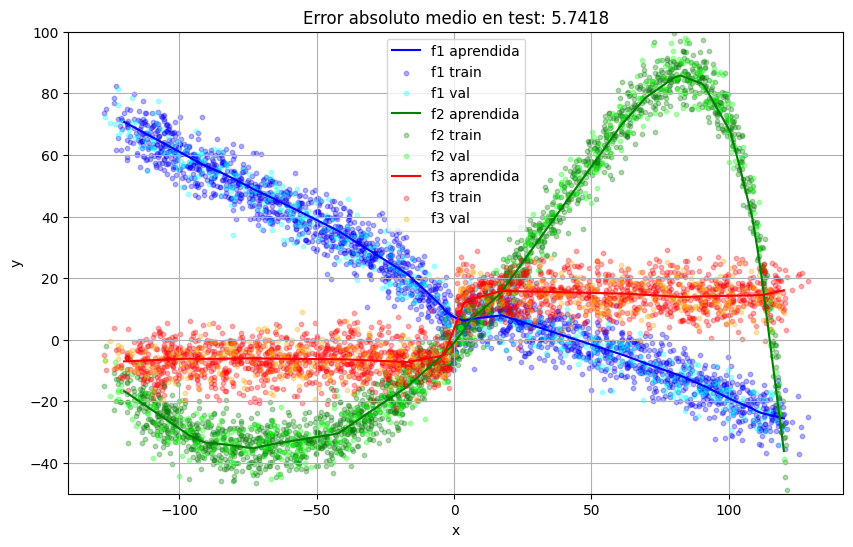

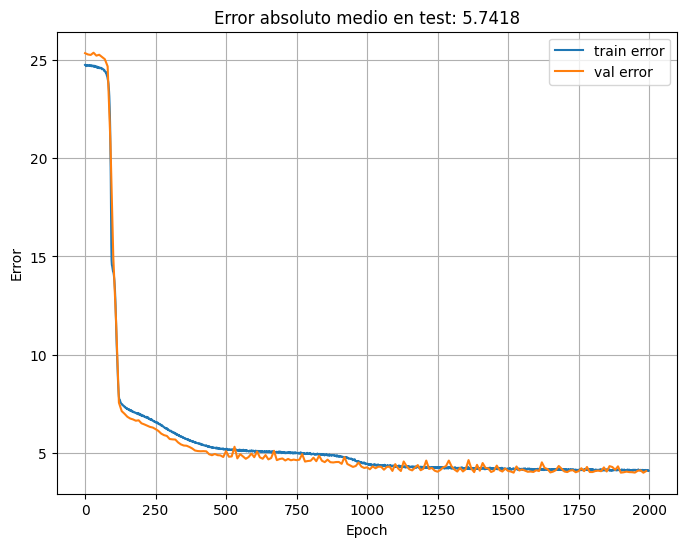

In [5]:
# Modelo
model = torch.nn.Sequential(
    torch.nn.Linear(1,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,32),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(32,16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16,3),
)

# Hiperparámetros
epochs = 2000
learning_rate = 1e-3
loss_fn = torch.nn.L1Loss()
optimizer_cls = torch.optim.SGD

model, train_losses, val_losses = learning_loop_with_val(train_loader, val_loader, model, epochs, loss_fn, learning_rate, optimizer_cls)


# Calculamos el error medio de todas las épocas de validación
mean_val_error = sum(val_losses) / len(val_losses)
print(f"Error absoluto medio en validación: {mean_val_error:.4f}")


# PLOTS
# ----------------------------
# Convertimos dataset a tensores para plotear
x_full_range = torch.linspace(-120,120,500)[:,None]
x_plot_normalized = x_full_range / 120
y_plot = model(x_plot_normalized).detach()

plt.figure(figsize=(10,6))
plt.title(f"Error absoluto medio en test: {mean_val_error:.4f}")
plt.plot(x_full_range, y_plot[:,0], c='b', label='f1 aprendida')
plt.scatter(x_train, y_train_list[0], c='b', s=10, alpha=0.3, label='f1 train')
plt.scatter(x_val, y_val_list[0], c='cyan', s=10, alpha=0.3, label='f1 val')
plt.plot(x_full_range, y_plot[:,1], c='g', label='f2 aprendida')
plt.scatter(x_train, y_train_list[1], c='g', s=10, alpha=0.3, label='f2 train')
plt.scatter(x_val, y_val_list[1], c='lime', s=10, alpha=0.3, label='f2 val')
plt.plot(x_full_range, y_plot[:,2], c='r', label='f3 aprendida')
plt.scatter(x_train, y_train_list[2], c='r', s=10, alpha=0.3, label='f3 train')
plt.scatter(x_val, y_val_list[2], c='orange', s=10, alpha=0.3, label='f3 val')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-50, 100)
plt.show()


# Ploteamos la gráfica del error
plt.figure(figsize=(8,6))
plt.title(f"Error absoluto medio en test: {mean_val_error:.4f}")
plt.plot(train_losses, label="train error")
plt.plot(range(0, epochs, 10), val_losses, label="val error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()


Para este segundo experimento, el modelo es más complejo con más capas y neuronas. Esto le ha ayudado un poco a mejorar, y el error de validación ha bajado un poco más en comparación con el primer intento. Además, como se ve en los resultados, la representación de la función f2 ha mejorado, aunque todavía le falta algo más de precisión. Un modelo más grande puede ayudar pero todavía no es suficiente así que vamos a modificar otros parámetros.

### EXPERIMENTO 3

Modelo de 4 capas (64, 64, 32, 16) con 3000 épocas y tasa de aprendizaje 1e-2

100%|██████████| 3000/3000 [08:50<00:00,  5.65it/s]


Error absoluto medio en validación: 4.4222


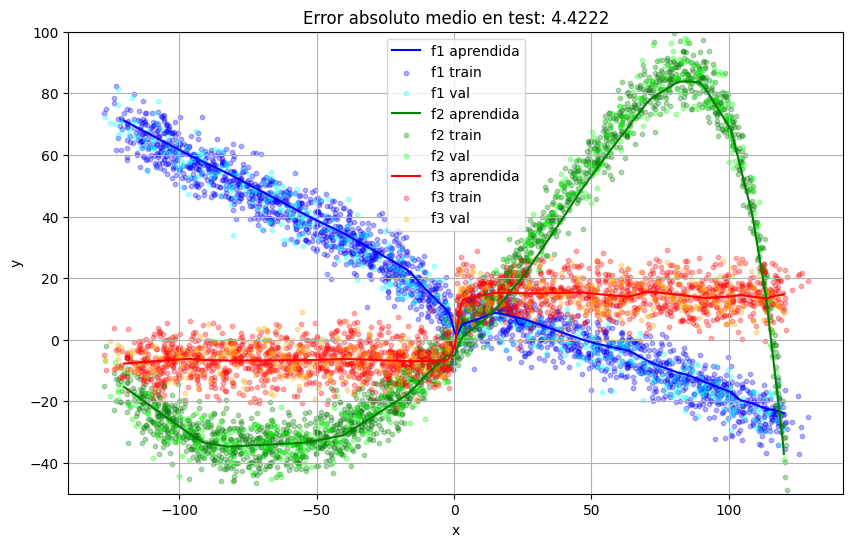

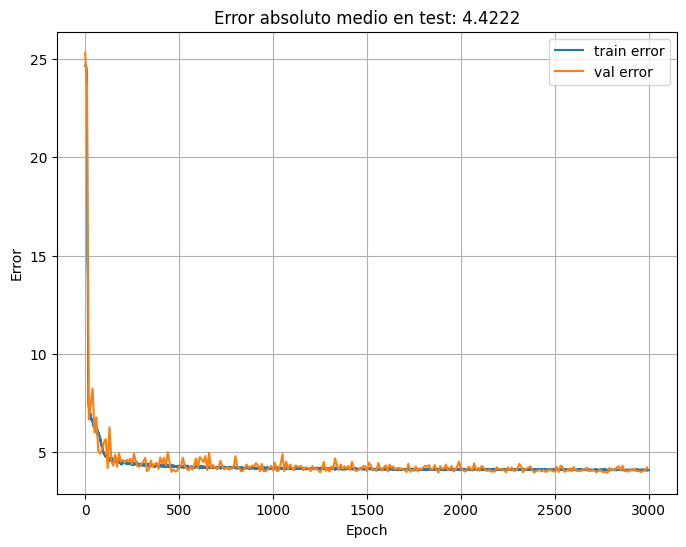

In [7]:
# Modelo
model = torch.nn.Sequential(
    torch.nn.Linear(1,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64,32),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(32,16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16,3),
)

# Hiperparámetros
epochs = 3000
learning_rate = 1e-2
loss_fn = torch.nn.L1Loss()
optimizer_cls = torch.optim.SGD

model, train_losses, val_losses = learning_loop_with_val(train_loader, val_loader, model, epochs, loss_fn, learning_rate, optimizer_cls)


# Calculamos el error medio de todas las épocas de validación
mean_val_error = sum(val_losses) / len(val_losses)
print(f"Error absoluto medio en validación: {mean_val_error:.4f}")


# PLOTS
# ----------------------------
# Convertimos dataset a tensores para plotear
x_full_range = torch.linspace(-120,120,500)[:,None]
x_plot_normalized = x_full_range / 120
y_plot = model(x_plot_normalized).detach()

plt.figure(figsize=(10,6))
plt.title(f"Error absoluto medio en test: {mean_val_error:.4f}")
plt.plot(x_full_range, y_plot[:,0], c='b', label='f1 aprendida')
plt.scatter(x_train, y_train_list[0], c='b', s=10, alpha=0.3, label='f1 train')
plt.scatter(x_val, y_val_list[0], c='cyan', s=10, alpha=0.3, label='f1 val')
plt.plot(x_full_range, y_plot[:,1], c='g', label='f2 aprendida')
plt.scatter(x_train, y_train_list[1], c='g', s=10, alpha=0.3, label='f2 train')
plt.scatter(x_val, y_val_list[1], c='lime', s=10, alpha=0.3, label='f2 val')
plt.plot(x_full_range, y_plot[:,2], c='r', label='f3 aprendida')
plt.scatter(x_train, y_train_list[2], c='r', s=10, alpha=0.3, label='f3 train')
plt.scatter(x_val, y_val_list[2], c='orange', s=10, alpha=0.3, label='f3 val')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-50, 100)
plt.show()


# Ploteamos la gráfica del error
plt.figure(figsize=(8,6))
plt.title(f"Error absoluto medio en test: {mean_val_error:.4f}")
plt.plot(train_losses, label="train error")
plt.plot(range(0, epochs, 10), val_losses, label="val error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()


En el tercer y último experimento mantenemos el modelo del segundo intento, pero ha tenido mucho más tiempo para aprender (más épocas de entrenamiento) y se ha ajustado la velocidad a la que aprendía (tasa de aprendizaje más baja). El resultado fue mucho mejor. La red neuronal ahora sí es capaz de seguir la forma de las tres funciones con bastante precisión. La gráfica del error lo confirma, mostrando cómo tanto el error de entrenamiento como el de validación bajan de forma constante y el error medio mejora, esto significa que el modelo ha sido más efectivo aprendiendo.

Aunque los resultados sean buenos, el modelo sigue sin ser perfecto. Siempre hay margen de mejora, se le podrían añadir más capas/neuronas, aumentar las épocas o bajar la tasa de aprendizaje. Incluso podemos usar otro optimizador pero por el bien de esta práctica se ha usado el SGD ya que otros optimizadores podrían hacer el trabajo por nosotros.

### EVALUACIÓN EN TEST

Con este código podremos evaluar con el conjunto de test cualquiera de los experimentos realizados. Para la práctica, evaluaremos el tercero que ha sido el mejor de todos.

In [10]:
model.eval()
test_losses = []
with torch.no_grad():
    for x_test_batch, y_test_batch in test_loader:
        y_pred_batch = model(x_test_batch)
        loss = loss_fn(y_pred_batch, y_test_batch)
        test_losses.append(loss.item())

# Calculamos el error medio absoluto final en el conjunto de test
mean_test_error = sum(test_losses) / len(test_losses)
print(f"Error absoluto medio final en el conjunto de test: {mean_test_error:.4f}")

Error absoluto medio final en el conjunto de test: 4.3093


En esta última parte, ponemos a prueba el modelo final (el del Experimento 3) con un conjunto de datos de "test". Estos son datos que el modelo no ha visto nunca, ni durante el entrenamiento ni en la validación, ya que no ha sido entrenado con ninguno de estos. El objetivo es comprobar si el modelo es realmente bueno para generalizar y predecir resultados con información nueva. Como hemos obtenido un error absoluto medio relativamente bajo, se demuestra que el entrenamiento fue un éxito. Podríamos decir que el modelo no solo memorizó los datos que ya conocía, sino que aprendió de verdad las tres funciones.